### 데이콘 비트코인 가격 예측 - Neural Prophet

In [1]:
import os, datetime
import numpy as np
import pandas as pd
from tqdm import tqdm

import IPython
import IPython.display
import matplotlib.pyplot as plt


from fbprophet import Prophet


Importing plotly failed. Interactive plots will not work.


In [2]:
### ------------ Data upload part ---------------- ###

# 데이터가 위치한 폴더 경로
dir_path = './data'

# 파일명 설정
test_file_name = 'test_x_df.csv'
test_file_path = os.path.join(dir_path, test_file_name)

#파일 업로드
test_x = pd.read_csv(test_file_path)
print("Reading Complete!")


Reading Complete!


In [3]:
# vwap과, open에서 vwap을 뺀 값인 diff를 계산합니다.
def make_vwap_and_diff(df):

    # 1) VAWP 계산

    # 일반적인 VWAP 공식에서 volume을 그대로 사용하지만, 여러번의 시도를 통해 tb_base_av 와 volume을 더했을 때 가장 좋은 volume이 나온다고 판단하영 사용하였습니다.
    df["volume_tb_base_av"] = df["tb_base_av"] + df["volume"]

    # open하나만을 사용하기 보다는 open(시가), high(고가), low(저가) 3개의 평균을 price로 사용하였습니다.
    df['volume_price'] = ((df['open'] + df['high']) / 2) * df['volume_tb_base_av']

    # price와 volume의 곱의 합을 구해줍니다.
    df['volume_price_sum'] = df.groupby(['sample_id'])['volume_price'].apply(lambda x: x.cumsum())

    # volume의 합을 구해줍니다.
    df['volume_sum'] = df.groupby(['sample_id'])['volume_tb_base_av'].apply(lambda x: x.cumsum())

    # 2 변수의 나눗셈을 통해 vwap을 계산해줍니다.
    df['vwap'] = df['volume_price_sum'] / df['volume_sum']


    # 2) diff 계산
    # 매도수익이 open을 통해 이루어진다고 알려져있기 때문에 open에서 vwap을 뺀 값을 diff로 사용했습니다.
    df["diff"] = df["open"] - df["vwap"]

    return df
    

In [4]:
# 데이터 프레임에서 sample_id 에 따른 open을 반환하는 함수입니다.
def get_open(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['open'].values
    
# 데이터 프레임에서 sample_id 에 따른 VWAP을 반환하는 함수입니다.
def get_vwap(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['vwap'].values
    
# 데이터 프레임에서 sample_id 에 따른 diff 반환하는 함수입니다.
def get_diff(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['diff'].values

# 데이터 프레임에서 sample_id 에 따른 rsi 반환하는 함수입니다.
def get_rsi(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['rsi'].values

# 데이터 프레임에서 sample_id 에 따른 col_name 값을 반환하는 함수입니다.
def get_series(df,sample_id, col_name):
    
    return df[df["sample_id"] == sample_id][col_name].values
    

In [5]:
# RSI를 만들어줍니다.
# 상승분, 하락분의 평균은 일반적으로 14일을 기준으로 생성합니다.
def make_rsi(df, period=25):

    # 전일 대비 상승분을 계산해줍니다. - 상승분이 0보다 크면 상승분을 넣고, 0보다 작거나 같으면 0을 넣어줍니다.
    df["U"] = np.where(df.groupby(["sample_id"])["open"].diff(1) > 0, df.groupby(["sample_id"])["open"].diff(1), 0)

    # 전일 대비 하락분을 계산해줍니다. - 하락분이 0보다 작으면 하락분 * -1을 넣고, 0보다 크거나 같으면 0을 넣어줍니다.
    df["D"] = np.where(df.groupby(["sample_id"])["open"].diff(1) < 0, df.groupby(["sample_id"])["open"].diff(1) *(-1), 0)


    # 전일 대비 상승분의 평균을 계산해줍니다.
    ud_df = pd.DataFrame()
    ud_df["sample_id"] = df["sample_id"]
    ud_df["U"] = df["U"]
    ud_df["D"] = df["D"]

    # 상승분의 14일 평균을 구해줍니다.
    df["AU"] = ud_df.groupby(["sample_id"])["U"].rolling( window=period, min_periods=period ).mean().reset_index()["U"]
    # 하락분의 14일 평균을 구해줍니다.
    df["AD"] = ud_df.groupby(["sample_id"])["D"].rolling( window=period, min_periods=period ).mean().reset_index()["D"]


    # AU / (AU + AD) 의 백분율을 RSI 로 계산해줍니다.
    RSI = df["AU"] / (df["AU"] + df["AD"]) * 100
    
    df["rsi"] = RSI
    
    return df
    

In [6]:
# 1. train, test의 sample_id 목록을 저장합니다.
TEST_SAMPLE_ID_LIST = test_x["sample_id"].unique().tolist()

In [7]:
# 2. VWAP, diff 를 만들어줍니다.
test_x = make_vwap_and_diff(test_x)

In [8]:
# 3. rsi 를 만들어줍니다.
test_x = make_rsi(test_x, 25)

In [24]:
# modeling programing
def prophet_modeling(input_array):

    x_df = prophet_preprocessor(input_array)

    model = Prophet(
                  changepoint_range = 1,
                  changepoint_prior_scale=0.01,
                  interval_width =0.9,
                  seasonality_mode = 'multiplicative',
                  yearly_seasonality = False, weekly_seasonality = False, daily_seasonality = False,
                 )

    model.add_seasonality(name='first_seasonality', period=1/24, fourier_order= 5) 
    model.add_seasonality(name='second_seasonality', period=1/12, fourier_order= 10)

    metrics = model.fit(x_df)

    future = model.make_future_dataframe(periods=120, freq="min")
    forecast = model.predict(future)

#     # display clear
#     IPython.display.clear_output()
    
    output = forecast.yhat.values[-120:]
    return output


def prophet_preprocessor(x_series):
    ''' 함수 설명 : 빈 x_df 만들기'''
    # start time initialization
    start_time = '2021-01-01 00:00:00'
    start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')

    # datafram 만들기
    x_df = pd.DataFrame()
    # 분당 시간 데이터 시리즈 입력
    x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
    # 가격 데이터 시리즈 입력
    x_df['y'] = x_series.tolist()

    return x_df

In [31]:
for sample_id in tqdm(TEST_SAMPLE_ID_LIST):
    
    # 1. 데이터 로드
    # 1) diff - 학습에 사용
    diff_x = get_diff(test_x, sample_id)
    open_x = get_open(test_x, sample_id)
    
    break

  0%|                                                                                          | 0/760 [00:00<?, ?it/s]


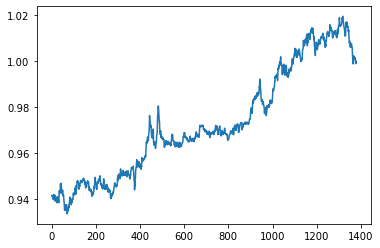

In [33]:
plt.plot(open_x)

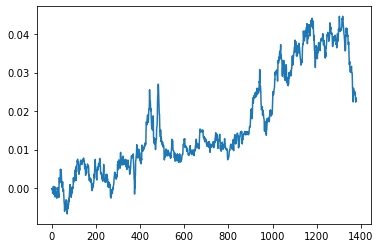

In [32]:
plt.plot(diff_x)

In [13]:
diff_x.shape

(1380,)

In [27]:
FORECAST = prophet_modeling(diff_x)

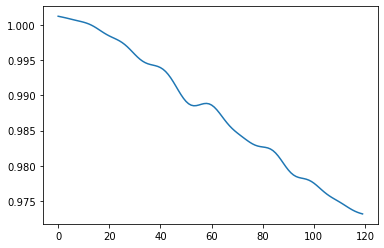

In [30]:
plt.plot(FORECAST)

In [34]:
FORECAST2 = prophet_modeling(diff_x)

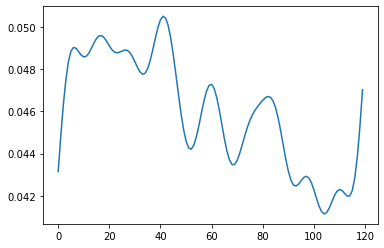

In [35]:
plt.plot(FORECAST2)

In [ ]:
result = [];

for sample_id in tqdm(TEST_SAMPLE_ID_LIST):
    
    # 1. 데이터 로드
    # 1) diff - 학습에 사용
    diff_x = get_diff(test_x, sample_id)

    # 2) vwap - 보조 지표로 사용
    vwap_series = get_vwap(test_x, sample_id)

    # 3) rsi - 보조 지표로 사용
    rsi_series = get_rsi(test_x, sample_id)
    
    
    # 2) MODEL PREDICTION

    FORECAST = prophet_modeling(diff_x)

    # 3. 데이처 처리
    # 1) 최대 부분인 인덱스를 찾는데 해당 시점에 매도를 진행합니다.
    sell_time = np.argmax(FORECAST)

    # 2) 최대값을 찾습니다.
    max_val = np.max(FORECAST)
    
    # 3) vwap의 마지막 값을 가져옵니다.
    vwap_last_val = vwap_series[1379]
    rsi_last_val = rsi_series[1379]
    
    
    # 4. 투자 전략
    buy_quantity = 0

    # 1) 최대값이 0 보다 크면 가격이 vwap 보다 크다는 의미로, 투자합니다.
    if  max_val > 0:
        buy_quantity = 1


    # 2) 만약 vwap 마지막 값이, 1보다 크면 가격이 1보다 작다는 의미로 하향세이기 때문에 투자하지 않습니다.
    if vwap_last_val > 1 and sell_time < 50:
        buy_quantity = 0

    # 3) 만약 rsi의 값이 65 보다 크면, 초과매수 상태로 판단하여 투자하지 않습니다.
    if rsi_last_val > 65 and sell_time < 50:
        buy_quantity = 0
        
   # 5. 결과
    result_list = [
                   sample_id,
                   buy_quantity,
                   sell_time
                  ]

    result.append(result_list)


 99%|██████████████████████████████████████████████████▍| 752/760 [1:05:02<00:28,  3.53s/it]

In [ ]:
submit_columns = [
                  "sample_id", 
                  "buy_quantity", 
                  "sell_time"
                  ]


submit = pd.DataFrame(data=result, columns=submit_columns)

In [ ]:
submit.head(10)

In [ ]:
submit[submit["buy_quantity"] == 1].shape[0]

In [ ]:
# 4. sell_time 50미만에서 구매하는 개수 확인
cond1 = (submit["buy_quantity"] == 1)
cond2 = (submit["sell_time"] < 50)

submit[cond1 & cond2].shape[0]

In [ ]:
FILE_NAME = "/prophet.csv"
RESULT_PATH = "./results" + FILE_NAME

submit.to_csv(RESULT_PATH, index=False)

In [4]:
# 모델링 시작
valid_pred_array = neural_prophet_modeling(FFD_train_x_array)
save_file_name = 'FFD_neural_prophet_result2.csv'
np.savetxt(save_file_name, valid_pred_array, delimiter = ",")



    NOTE : 383의 샘플 내 0개의 샘플에서 에러가 발생했습니다.

    Prediction Complete!'
    
